SVM Classifier

In [1]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
import re
import nltk
from nltk.stem import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from PIL import _imaging
from sklearn.svm import SVC
from numpy import genfromtxt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
import csv
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report, confusion_matrix




def cor_selector(X, y, num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:, np.argsort(
        np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


data = pd.read_csv('out.csv')
df = data
df = df.drop(columns=['Label'])
X = df
print(np.shape(X))
y = data['Label']
print(np.shape(X))


num_feats = 850
feature_name = X.columns.tolist()
cor_support, cor_feature = cor_selector(X, y, num_feats)

our_feature = []

our_feature.append(["Pearson Correlation", cor_feature])


# Chi-Squared
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:, chi_support].columns.tolist()


our_feature.append(["Chi-Squared", chi_feature])

# Recursive Feature Elimination
rfe_selector = RFE(estimator=LogisticRegression(),
                   n_features_to_select=num_feats, step=30, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:, rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')


our_feature.append(["Recursive Feature Elimination", rfe_feature])


# Random Forest

embeded_rf_selector = SelectFromModel(
    RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:, embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

our_feature.append(["Random Forest", embeded_rf_feature])

# LightGBM


lgbc = LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                      reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
embeded_lgb_selector.fit(X, y)

embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:, embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

our_feature.append(["LightGBM", embeded_lgb_feature])




(2479, 988)
(2479, 988)
Fitting estimator with 988 features.
Fitting estimator with 958 features.
Fitting estimator with 928 features.
Fitting estimator with 898 features.
Fitting estimator with 868 features.
850 selected features
206 selected features
210 selected features


--------------------------------------- Pearson Correlation ------------------------------
(2479, 850)
2479
Training Accuracy: 100.0 %
Test Accuracy: 90.34289713086075 %
	 TP	FP	TN	FN

0.0	 417 	 54 	 913 	 45
1.0	 424 	 59 	 869 	 77
2.0	 450 	 25 	 938 	 16

Classification Report

              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89       471
         1.0       0.85      0.88      0.86       483
         2.0       0.97      0.95      0.96       475

    accuracy                           0.90      1429
   macro avg       0.90      0.90      0.90      1429
weighted avg       0.90      0.90      0.90      1429



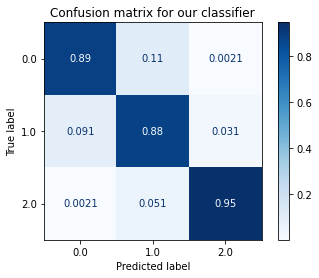

--------------------------------------- Chi-Squared ------------------------------
(2479, 850)
2479
Training Accuracy: 100.0 %
Test Accuracy: 91.46256123163052 %
	 TP	FP	TN	FN

0.0	 421 	 50 	 919 	 39
1.0	 428 	 55 	 881 	 65
2.0	 458 	 17 	 936 	 18

Classification Report

              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90       471
         1.0       0.87      0.89      0.88       483
         2.0       0.96      0.96      0.96       475

    accuracy                           0.91      1429
   macro avg       0.92      0.91      0.91      1429
weighted avg       0.91      0.91      0.91      1429



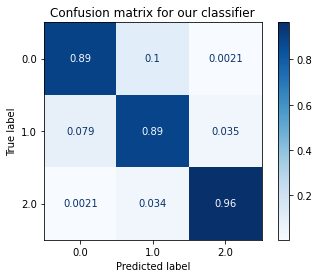

--------------------------------------- Recursive Feature Elimination ------------------------------
(2479, 850)
2479
Training Accuracy: 100.0 %
Test Accuracy: 90.76277116864941 %
	 TP	FP	TN	FN

0.0	 428 	 43 	 909 	 49
1.0	 417 	 66 	 884 	 62
2.0	 452 	 23 	 933 	 21

Classification Report

              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90       471
         1.0       0.87      0.86      0.87       483
         2.0       0.96      0.95      0.95       475

    accuracy                           0.91      1429
   macro avg       0.91      0.91      0.91      1429
weighted avg       0.91      0.91      0.91      1429



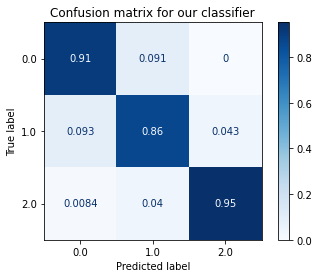

--------------------------------------- Random Forest ------------------------------
(2479, 206)
2479
Training Accuracy: 98.4747378455672 %
Test Accuracy: 90.83275017494752 %
	 TP	FP	TN	FN

0.0	 436 	 35 	 909 	 49
1.0	 417 	 66 	 890 	 56
2.0	 445 	 30 	 928 	 26

Classification Report

              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91       471
         1.0       0.88      0.86      0.87       483
         2.0       0.94      0.94      0.94       475

    accuracy                           0.91      1429
   macro avg       0.91      0.91      0.91      1429
weighted avg       0.91      0.91      0.91      1429



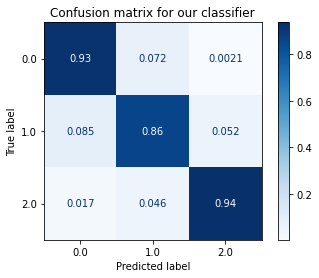

--------------------------------------- LightGBM ------------------------------
(2479, 210)
2479


In [5]:
from sklearn.metrics import classification_report, confusion_matrix
my_data = pd.read_csv('out.csv')
for i in our_feature:
    
    print("---------------------------------------",
          i[0], "------------------------------")
    # print(my_data.head)
    # print(i[1])
    df = my_data[i[1]]
    # df = my_data
    X_ori = np.array(df)
    print(np.shape(X_ori))
    Y_ori = np.array(my_data['Label'])
    # print(type(my_data))

    data_length = np.shape(X_ori)[0]
    print(data_length)
    data_length = 1500
    train_len = (int)(data_length*(0.7))
    test_len = (data_length-train_len)
    y_train = Y_ori[1:train_len]
    y_test = Y_ori[train_len:]
    X_train = X_ori[1:train_len, :-1]
    X_test = X_ori[train_len:, :-1]

    # print(X_ori)

    eeg_svc = SVC(C=1.0, kernel="linear")
    # print(type(eeg_svc))

    eeg_svc.fit(X_train, y_train.ravel())
    print("Training Accuracy:", (eeg_svc.score(X_train, y_train.ravel()))*100, "%")

    y_pred = eeg_svc.predict(X_test)
    print("Test Accuracy:", (eeg_svc.score(X_test, y_test.ravel()))*100, "%")
    matrix = plot_confusion_matrix(eeg_svc,
                               X_test,
                               y_test,
                               cmap=plt.cm.Blues,
                               normalize='true')
    plt.title('Confusion matrix for our classifier')
    confusion = confusion_matrix(y_test, y_pred)
  
    confusion= confusion.flatten()
  
    print('\t TP\tFP\tTN\tFN')
    print()

    print('0.0\t',confusion[0],'\t',confusion[1]+confusion[2],'\t',confusion[4]+confusion[5]+confusion[7]+confusion[8],'\t',confusion[3]+confusion[6])
    print('1.0\t',confusion[4],'\t',confusion[3]+confusion[5],'\t',confusion[0]+confusion[2]+confusion[6]+confusion[8],'\t',confusion[1]+confusion[7])
    print('2.0\t',confusion[8],'\t',confusion[6]+confusion[7],'\t',confusion[0]+confusion[1]+confusion[3]+confusion[4],'\t',confusion[2]+confusion[5])
  
    print('\nClassification Report\n')
    print(classification_report(y_test, y_pred, target_names=['0.0', '1.0', '2.0']))


    plt.show()
    

